# SARIMA Analysis 

In [1]:
import os
import pandas as pd
import numpy as np

## Simple EDA 

From the plot, our team decided to use data from 2023-10-15 to 2024-03-16 as our training data and use data from 2024-10-20 to 2024-11-10 as our test dataset. 

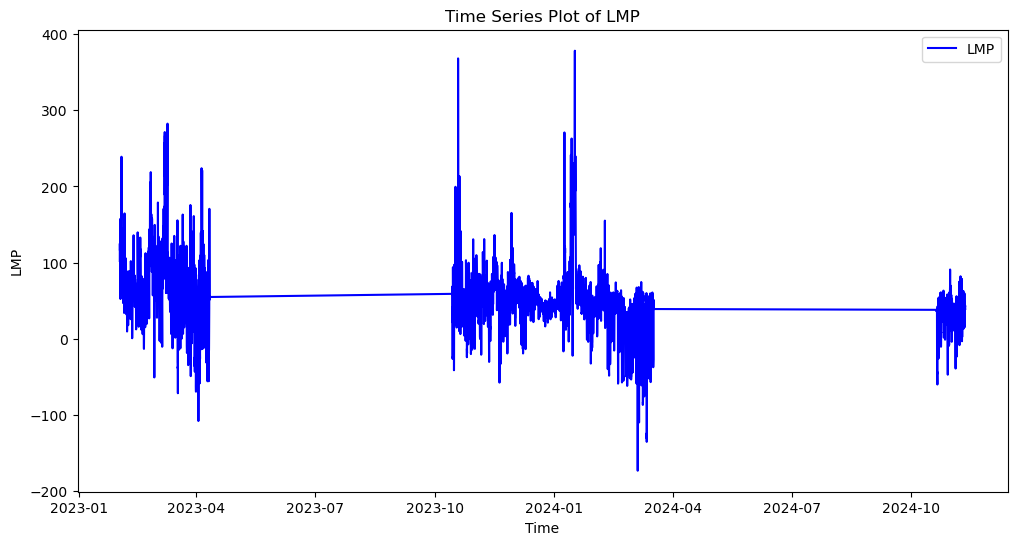

In [24]:
data = pd.read_csv('./data_seg6.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

lmp_data = data['LMP']

# visualize trends and seasonality
plt.figure(figsize=(12, 6))
plt.plot(lmp_data, label='LMP', color='blue')
plt.title('Time Series Plot of LMP')
plt.xlabel('Time')
plt.ylabel('LMP')
plt.legend()
plt.show()

## Segment 6 SARIMA

### SARIMA Parameter Tuning Using Grid Search

From the exploratory data anaylsis, we discovered that the dataset clearly exhibits clear MA/AR components. Also, we discovered electricity price is fairly stationary and contains clear seasonal pattern. Therefore, we decided to tune on p,d,q,P,D,Q using the grid search using training dataset. We assume parameter s to be 24 since electricity price has daily seasonal pattern. 

In [29]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX


data = pd.read_csv('./data_seg6.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)
filtered_data = data.loc['2023-10-15':'2024-03-16']

# Assign hourly frequency and handle missing values
filtered_data = filtered_data.asfreq('H')
filtered_data = filtered_data.fillna(method='ffill')

# Split data into train and test sets
train_size = int(len(filtered_data) * 0.8)
train, test = filtered_data['LMP'][:train_size], filtered_data['LMP'][train_size:]

# Grid search for SARIMA parameters
def sarima_grid_search(train, p_values, d_values, q_values, P_values, D_values, Q_values, s):
    best_aic = float("inf")
    best_params = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                model = SARIMAX(
                                    train,
                                    order=(p, d, q),
                                    seasonal_order=(P, D, Q, s),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False
                                )
                                model_fit = model.fit(disp=False)
                                aic = model_fit.aic
                                if aic < best_aic:
                                    best_aic = aic
                                    best_params = (p, d, q, P, D, Q, s)
                            except:
                                continue
    return best_params, best_aic

p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]
P_values = [0, 1]
D_values = [0, 1]
Q_values = [0, 1]
s = 24  # Daily seasonality

# Perform grid search
best_params, best_aic = sarima_grid_search(train, p_values, d_values, q_values, P_values, D_values, Q_values, s)
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)


C:\Users\isaac\AppData\Local\Temp\ipykernel_6788\2997254887.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data = filtered_data.fillna(method='ffill')
C:\Users\isaac\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\isaac\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best Parameters: (2, 0, 2, 1, 1, 1, 24)
Best AIC: 23433.454741870868


### Tuned Model Performance 

In [62]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

data = pd.read_csv('./data_seg6.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

filtered_data = data.loc['2023-10-15':'2024-03-16']

# Assign hourly frequency and handle missing values
filtered_data = filtered_data.asfreq('H')
filtered_data = filtered_data.fillna(method='ffill')

# Split the data into training and testing sets
train_size = int(len(filtered_data) * 0.8)
train, test = filtered_data['LMP'][:train_size], filtered_data['LMP'][train_size:]

# Define the best SARIMA parameters
sarima_order_best = (2, 0, 2)
seasonal_order_best = (1, 1, 1, 24)

# Fit the SARIMA model with the best parameters
model_best = SARIMAX(train, order=sarima_order_best, seasonal_order=seasonal_order_best, enforce_stationarity=False, enforce_invertibility=False)
sarima_fit_best = model_best.fit(disp=False)

# Forecast on the test set
test_predictions_best = sarima_fit_best.predict(start=test.index[0], end=test.index[-1])

rmse_best = np.sqrt(mean_squared_error(test, test_predictions_best))

print("RMSE:", rmse_best)
print(sarima_fit_best.summary())


C:\Users\isaac\AppData\Local\Temp\ipykernel_9940\1287320196.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data = filtered_data.fillna(method='ffill')


RMSE: 42.570005559289605
                                      SARIMAX Results                                       
Dep. Variable:                                  LMP   No. Observations:                 2956
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 24)   Log Likelihood              -11709.727
Date:                              Thu, 21 Nov 2024   AIC                          23433.455
Time:                                      13:54:42   BIC                          23475.274
Sample:                                  10-15-2023   HQIC                         23448.522
                                       - 02-15-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5516      0.032     48.063      0.000       1.488       

### Prediction on the Training Dataset

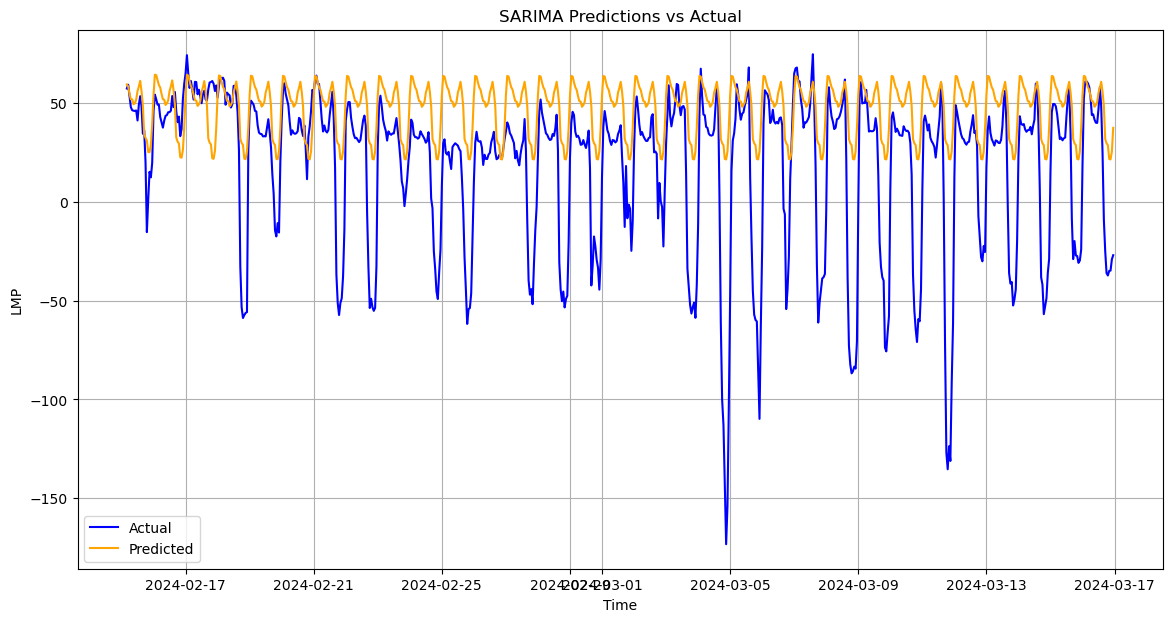

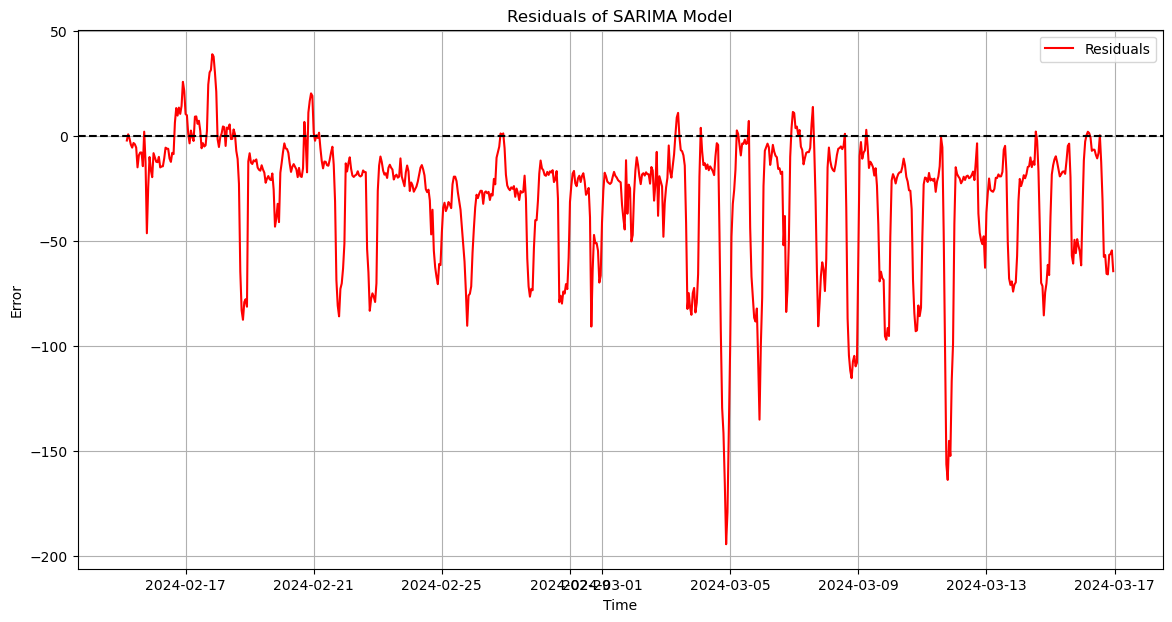

In [64]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test, label='Actual', color='blue')
plt.plot(test_predictions_best, label='Predicted', color='orange')
plt.title('SARIMA Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('LMP')
plt.legend()
plt.grid()
plt.show()

# Plot residuals (errors)
residuals = test - test_predictions_best
plt.figure(figsize=(14, 7))
plt.plot(residuals, label='Residuals', color='red')
plt.axhline(0, linestyle='--', color='black')
plt.title('Residuals of SARIMA Model')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()

### Prediction on the test dataset

C:\Users\isaac\AppData\Local\Temp\ipykernel_20760\1723001742.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data = filtered_data.asfreq('H').fillna(method='ffill')


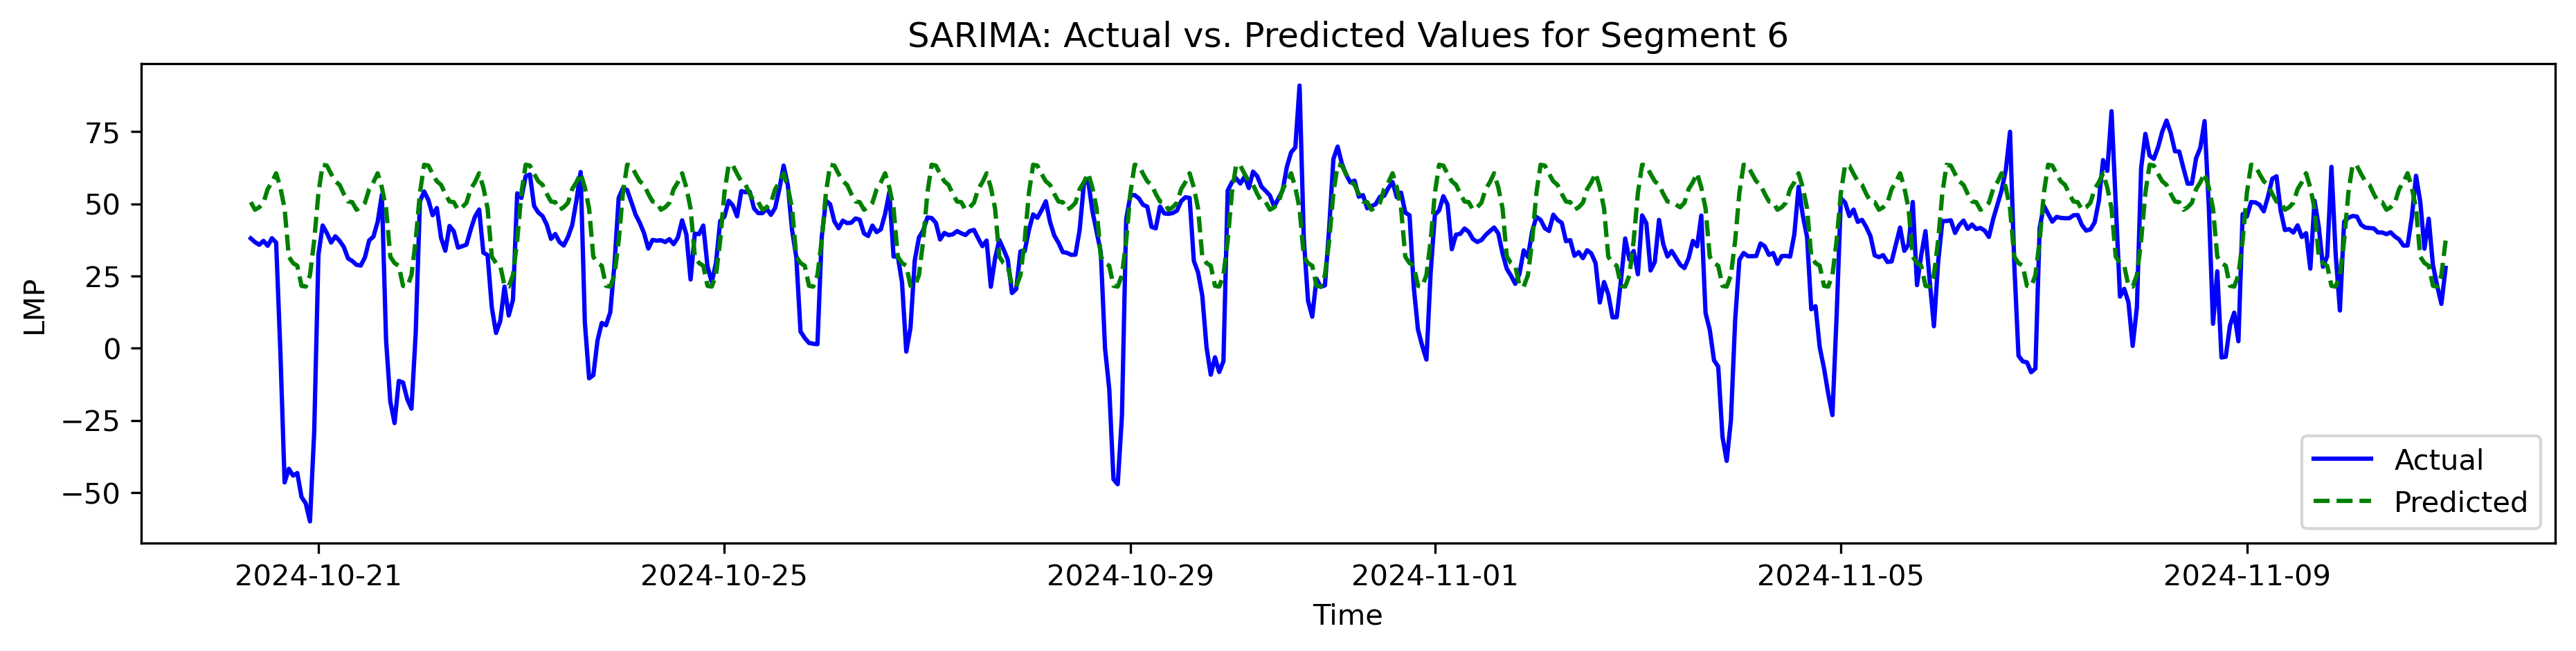

RMSE for the Forecasted Range: 20.560034200825864


In [67]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the actual dataset
actual_data = pd.read_csv('./data_seg6.csv')
actual_data['Time'] = pd.to_datetime(actual_data['Time'])
actual_data.set_index('Time', inplace=True)

# Filter the actual data for the forecasted range
actual_values = actual_data.loc['2024-10-20':'2024-11-10', 'LMP']

# Reload original dataset for SARIMA fitting
data = pd.read_csv('data_seg6.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

filtered_data = data.loc['2023-10-15':'2024-03-16']
filtered_data = filtered_data.asfreq('H').fillna(method='ffill')
train_size = int(len(filtered_data) * 0.8)
train = filtered_data['LMP'][:train_size]

# Fit SARIMA model with best parameters
sarima_order_best = (2, 0, 2)
seasonal_order_best = (1, 1, 1, 24)
model_best = SARIMAX(train, order=sarima_order_best, seasonal_order=seasonal_order_best, enforce_stationarity=False, enforce_invertibility=False)
sarima_fit_best = model_best.fit(disp=False)

# Forecast for the desired range
forecast_start = '2024-10-20 00:00:00'
forecast_end = '2024-11-10 23:00:00'
future_forecast = sarima_fit_best.get_prediction(start=forecast_start, end=forecast_end)
forecast_mean = future_forecast.predicted_mean

forecast_mean_aligned = forecast_mean.reindex(actual_values.index)

# Compare actual vs predicted values


fig, ax = plt.subplots(figsize=(15, 3), dpi=300)
ax.plot(actual_values, label='Actual', color = 'blue')
ax.plot(forecast_mean_aligned, label='Predicted', color = 'green', linestyle = '--')
ax.set_xlabel('Time')
ax.set_ylabel('LMP')
ax.set_title('SARIMA: Actual vs. Predicted Values for Segment 6')
ax.legend()

plt.show()


#plt.figure(figsize=(15, 5), dpi = 300)
#plt.plot(actual_values, label='Actual', color='blue')
#plt.plot(forecast_mean_aligned, label='Predicted', color='green', linestyle = '--')
#plt.title('SARIMA: Actual vs. Predicted Values for Segment 6')
#plt.xlabel('Time')
#plt.ylabel('LMP')
#plt.legend()
#plt.show()

# Calculate RMSE after alignment
rmse_forecast = np.sqrt(mean_squared_error(actual_values, forecast_mean_aligned))
print("RMSE for the Forecasted Range:", rmse_forecast)


### Prediction on the Specific Interval (2024-11-01 4AM-11AM / 8AM-4PM) 

C:\Users\isaac\AppData\Local\Temp\ipykernel_20760\657268615.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data = filtered_data.asfreq('H').fillna(method='ffill')


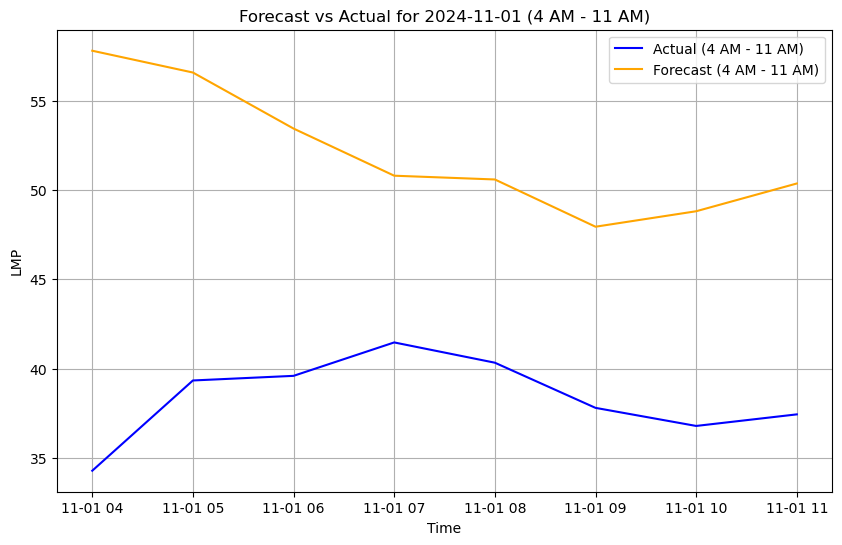

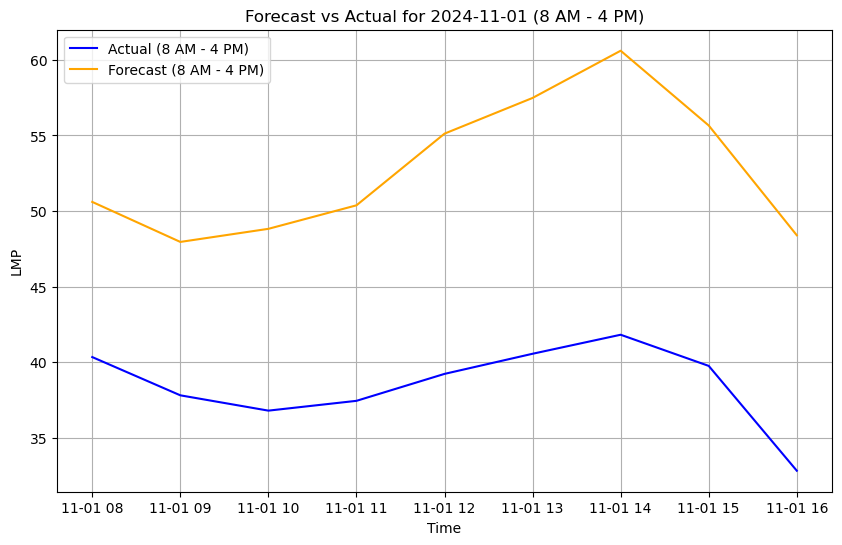

RMSE (4 AM - 11 AM): 14.369562459216352
RMSE (8 AM - 4 PM): 14.565274046934654


In [54]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

data = pd.read_csv('./data_seg6.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

# Preprocess the data for SARIMA
filtered_data = data.loc['2023-10-15':'2024-03-16']
filtered_data = filtered_data.asfreq('H').fillna(method='ffill')
train_size = int(len(filtered_data) * 0.8)
train = filtered_data['LMP'][:train_size]

# Fit SARIMA model with best parameters
sarima_order_best = (2, 0, 2)
seasonal_order_best = (1, 1, 1, 24)
model_best = SARIMAX(train, order=sarima_order_best, seasonal_order=seasonal_order_best, enforce_stationarity=False, enforce_invertibility=False)
sarima_fit_best = model_best.fit(disp=False)

# Define specific periods
forecast_start_1 = '2024-11-01 04:00:00'
forecast_end_1 = '2024-11-01 11:00:00'
forecast_start_2 = '2024-11-01 08:00:00'
forecast_end_2 = '2024-11-01 16:00:00'

# Make predictions
future_forecast_1 = sarima_fit_best.get_prediction(start=forecast_start_1, end=forecast_end_1)
forecast_mean_1 = future_forecast_1.predicted_mean

future_forecast_2 = sarima_fit_best.get_prediction(start=forecast_start_2, end=forecast_end_2)
forecast_mean_2 = future_forecast_2.predicted_mean

# Extract actual values
actual_values_1 = data.loc[forecast_start_1:forecast_end_1, 'LMP']
actual_values_2 = data.loc[forecast_start_2:forecast_end_2, 'LMP']

# Align predictions
forecast_mean_1_aligned = forecast_mean_1.reindex(actual_values_1.index)
forecast_mean_2_aligned = forecast_mean_2.reindex(actual_values_2.index)

# Plot for period 1
plt.figure(figsize=(10, 6))
plt.plot(actual_values_1, label='Actual (4 AM - 11 AM)', color='blue')
plt.plot(forecast_mean_1_aligned, label='Forecast (4 AM - 11 AM)', color='orange')
plt.title('Forecast vs Actual for 2024-11-01 (4 AM - 11 AM)')
plt.xlabel('Time')
plt.ylabel('LMP')
plt.legend()
plt.grid()
plt.show()

# Plot for period 2
plt.figure(figsize=(10, 6))
plt.plot(actual_values_2, label='Actual (8 AM - 4 PM)', color='blue')
plt.plot(forecast_mean_2_aligned, label='Forecast (8 AM - 4 PM)', color='orange')
plt.title('Forecast vs Actual for 2024-11-01 (8 AM - 4 PM)')
plt.xlabel('Time')
plt.ylabel('LMP')
plt.legend()
plt.grid()
plt.show()

rmse_1 = np.sqrt(mean_squared_error(actual_values_1, forecast_mean_1_aligned))
rmse_2 = np.sqrt(mean_squared_error(actual_values_2, forecast_mean_2_aligned))

print("RMSE (4 AM - 11 AM):", rmse_1)
print("RMSE (8 AM - 4 PM):", rmse_2)


### Average Hourly Prediction (2024, Nov 1 - Nov 10)

In [56]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

data = pd.read_csv('./data_seg6.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

# Preprocess the data for SARIMA
filtered_data = data.loc['2023-10-15':'2024-03-16']
filtered_data = filtered_data.asfreq('H').fillna(method='ffill')
train_size = int(len(filtered_data) * 0.8)
train = filtered_data['LMP'][:train_size]

# Fit SARIMA model with best parameters
sarima_order_best = (2, 0, 2)
seasonal_order_best = (1, 1, 1, 24)
model_best = SARIMAX(train, order=sarima_order_best, seasonal_order=seasonal_order_best, enforce_stationarity=False, enforce_invertibility=False)
sarima_fit_best = model_best.fit(disp=False)

forecast_start_full = '2024-11-01 00:00:00'
forecast_end_full = '2024-11-10 23:00:00'

# Generate predictions for the full range
future_forecast_full = sarima_fit_best.get_prediction(start=forecast_start_full, end=forecast_end_full)
forecast_mean_full = future_forecast_full.predicted_mean

# Calculate the average hourly prediction
average_hourly_prediction = forecast_mean_full.mean()

print("Average Hourly Prediction (Nov 1 - Nov 10, 2024):", average_hourly_prediction)

C:\Users\isaac\AppData\Local\Temp\ipykernel_20760\874399883.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data = filtered_data.asfreq('H').fillna(method='ffill')


Average Hourly Prediction (Nov 1 - Nov 10, 2024): 47.078563895508815


# Segment 7 SARIMA

### SARIMA Parameter Tuning Using Grid Search

In [80]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

data = pd.read_csv('./data_seg7.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)
filtered_data = data.loc['2023-10-15':'2024-03-16']

# Assign hourly frequency and handle missing values
filtered_data = filtered_data.asfreq('H')
filtered_data = filtered_data.fillna(method='ffill')

# Split data train and test sets
train_size = int(len(filtered_data) * 0.8)
train, test = filtered_data['LMP'][:train_size], filtered_data['LMP'][train_size:]

# Grid search for SARIMA parameters
def sarima_grid_search(train, p_values, d_values, q_values, P_values, D_values, Q_values, s):
    best_aic = float("inf")
    best_params = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                model = SARIMAX(
                                    train,
                                    order=(p, d, q),
                                    seasonal_order=(P, D, Q, s),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False
                                )
                                model_fit = model.fit(disp=False)
                                aic = model_fit.aic
                                if aic < best_aic:
                                    best_aic = aic
                                    best_params = (p, d, q, P, D, Q, s)
                            except:
                                continue
    return best_params, best_aic

# Define SARIMA parameter ranges
p_values = [0, 1, 2]
d_values = [0, 1] # Should be 0 since the time series is farily staionary. 
q_values = [0, 1, 2]
P_values = [0, 1]
D_values = [0, 1]
Q_values = [0, 1]
s = 24  # Daily seasonality

# Perform grid search
best_params, best_aic = sarima_grid_search(train, p_values, d_values, q_values, P_values, D_values, Q_values, s)
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)


C:\Users\isaac\AppData\Local\Temp\ipykernel_9940\2030917059.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data = filtered_data.fillna(method='ffill')
C:\Users\isaac\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\isaac\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\isaac\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best Parameters: (2, 1, 2, 1, 1, 1, 24)
Best AIC: 23051.32092061988


### Tuned Model Performance 

In [92]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

data = pd.read_csv('./data_seg7.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

# Filter for the specified range
filtered_data = data.loc['2023-10-15':'2024-03-16']

# Assign hourly frequency and handle missing values
filtered_data = filtered_data.asfreq('H')
filtered_data = filtered_data.fillna(method='ffill')

# Split the data into training and testing sets
train_size = int(len(filtered_data) * 0.8)
train, test = filtered_data['LMP'][:train_size], filtered_data['LMP'][train_size:]

# Define the best SARIMA parameters
sarima_order_best = (2, 0, 2)
seasonal_order_best = (1, 1, 1, 24)

# Fit the SARIMA model with the best parameters
model_best = SARIMAX(train, order=sarima_order_best, seasonal_order=seasonal_order_best, enforce_stationarity=False, enforce_invertibility=False)
sarima_fit_best = model_best.fit(disp=False)

# Forecast on the test set
test_predictions_best = sarima_fit_best.predict(start=test.index[0], end=test.index[-1])

rmse_best = np.sqrt(mean_squared_error(test, test_predictions_best))

print("RMSE:", rmse_best)
print(sarima_fit_best.summary())


C:\Users\isaac\AppData\Local\Temp\ipykernel_9940\608826491.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data = filtered_data.fillna(method='ffill')


RMSE: 28.342677351032133
                                      SARIMAX Results                                       
Dep. Variable:                                  LMP   No. Observations:                 2956
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 24)   Log Likelihood              -11520.720
Date:                              Thu, 21 Nov 2024   AIC                          23055.440
Time:                                      17:16:12   BIC                          23097.259
Sample:                                  10-15-2023   HQIC                         23070.507
                                       - 02-15-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9934      0.122      8.159      0.000       0.755       

### Prediction on the Training Dataset

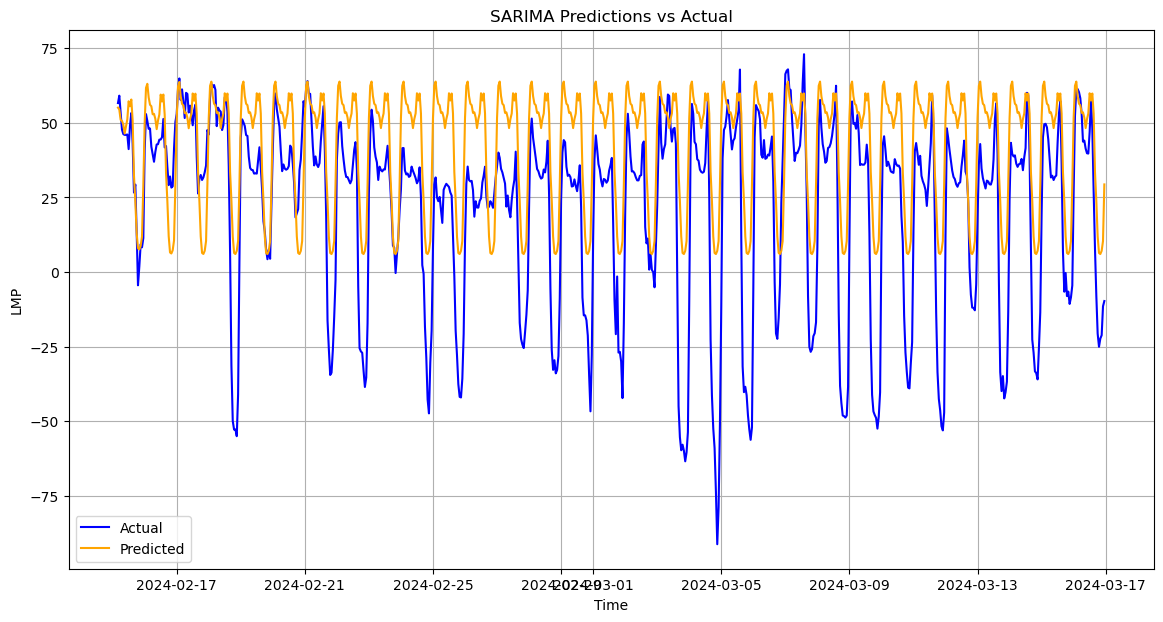

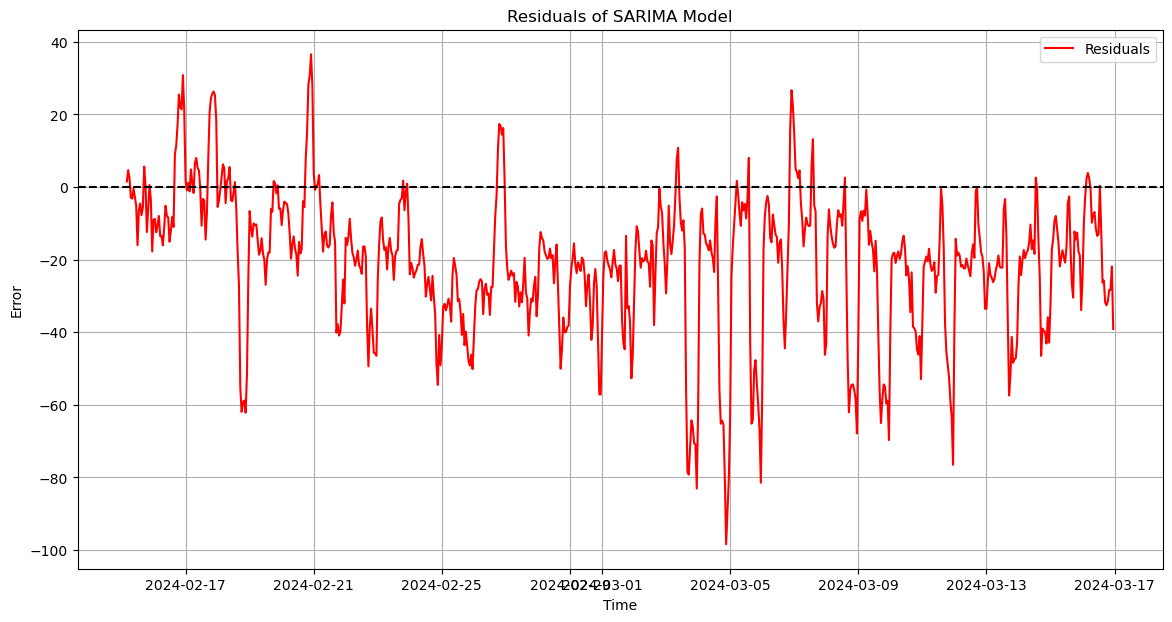

In [94]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test, label='Actual', color='blue')
plt.plot(test_predictions_best, label='Predicted', color='orange')
plt.title('SARIMA Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('LMP')
plt.legend()
plt.grid()
plt.show()

# Plot residuals (errors)
residuals = test - test_predictions_best
plt.figure(figsize=(14, 7))
plt.plot(residuals, label='Residuals', color='red')
plt.axhline(0, linestyle='--', color='black')
plt.title('Residuals of SARIMA Model')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()

### Prediction on the test dataset

C:\Users\isaac\AppData\Local\Temp\ipykernel_20760\3382878080.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data = filtered_data.asfreq('H').fillna(method='ffill')


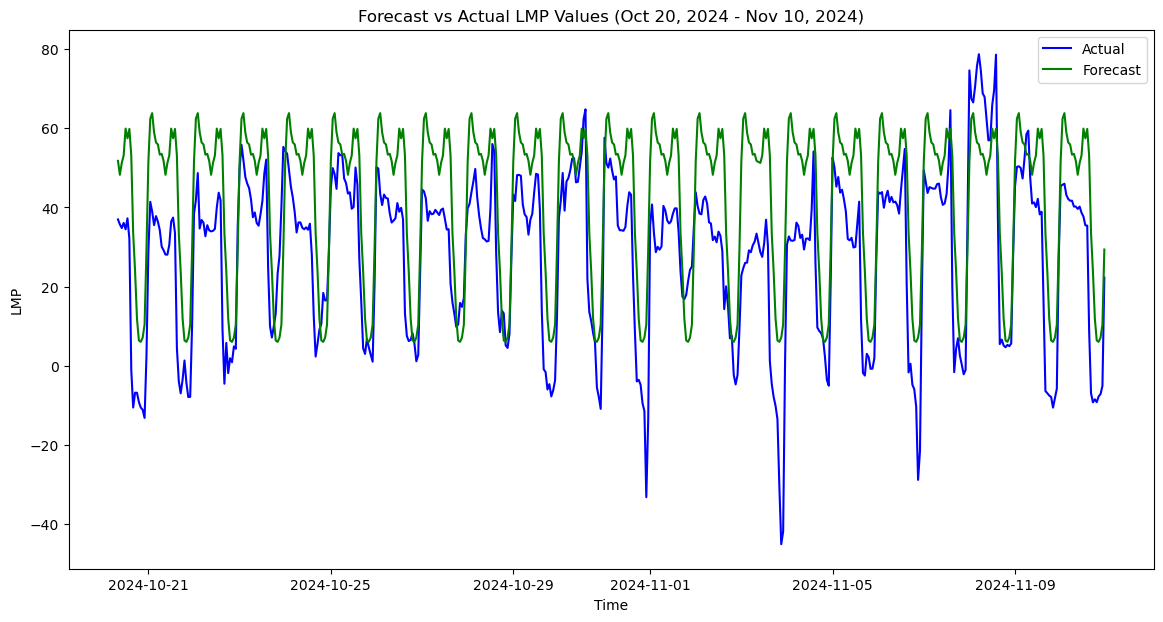

RMSE for the Forecasted Range: 18.900282002305552


In [15]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

actual_data = pd.read_csv('./data_seg7.csv')
actual_data['Time'] = pd.to_datetime(actual_data['Time'])
actual_data.set_index('Time', inplace=True)

# Filter the actual data for the forecasted range
actual_values = actual_data.loc['2024-10-20':'2024-11-10', 'LMP']

# Reload original dataset for SARIMA fitting
data = pd.read_csv('./data_seg7.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

filtered_data = data.loc['2023-10-15':'2024-03-16']
filtered_data = filtered_data.asfreq('H').fillna(method='ffill')
train_size = int(len(filtered_data) * 0.8)
train = filtered_data['LMP'][:train_size]

# Fit SARIMA model with best parameters
sarima_order_best = (2, 0, 2)
seasonal_order_best = (1, 1, 1, 24)
model_best = SARIMAX(train, order=sarima_order_best, seasonal_order=seasonal_order_best, enforce_stationarity=False, enforce_invertibility=False)
sarima_fit_best = model_best.fit(disp=False)

# Forecast for the desired range
forecast_start = '2024-10-20 00:00:00'
forecast_end = '2024-11-10 23:00:00'
future_forecast = sarima_fit_best.get_prediction(start=forecast_start, end=forecast_end)
forecast_mean = future_forecast.predicted_mean

forecast_mean_aligned = forecast_mean.reindex(actual_values.index)

# Compare actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actual_values, label='Actual', color='blue')
plt.plot(forecast_mean_aligned, label='Forecast', color='green')
plt.title('Forecast vs Actual LMP Values (Oct 20, 2024 - Nov 10, 2024)')
plt.xlabel('Time')
plt.ylabel('LMP')
plt.legend()
plt.show()

# Calculate RMSE after alignment
rmse_forecast = np.sqrt(mean_squared_error(actual_values, forecast_mean_aligned))
print("RMSE for the Forecasted Range:", rmse_forecast)

### Prediction on the Specific Interval (2024-11-01 4AM-11AM / 8AM-4PM) 

C:\Users\isaac\AppData\Local\Temp\ipykernel_20760\4102109492.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data = filtered_data.asfreq('H').fillna(method='ffill')


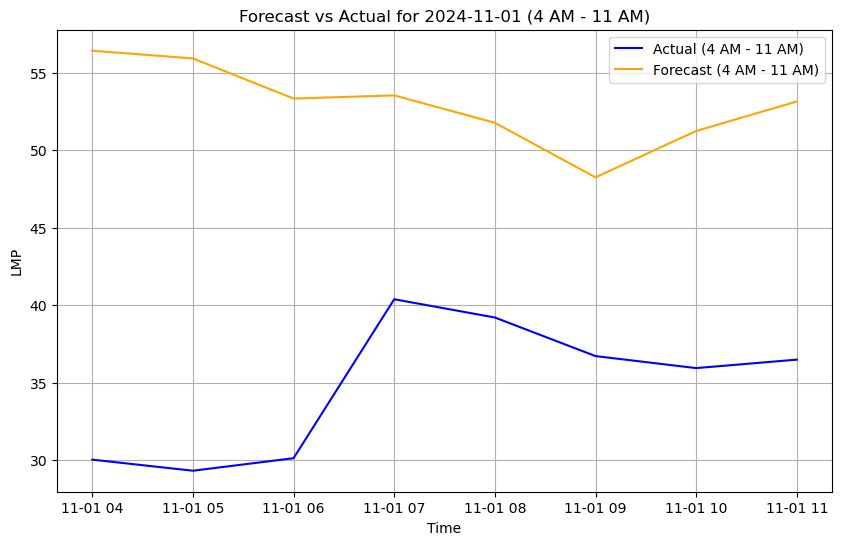

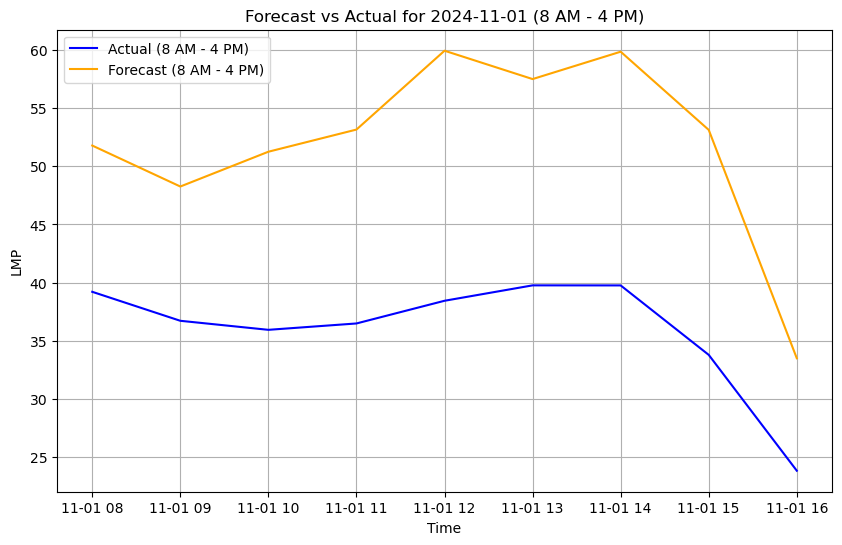

RMSE (4 AM - 11 AM): 19.100683482145712
RMSE (8 AM - 4 PM): 16.49334432721145


In [48]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

data = pd.read_csv('./data_seg7.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

# Preprocess the data for SARIMA
filtered_data = data.loc['2023-10-15':'2024-03-16']
filtered_data = filtered_data.asfreq('H').fillna(method='ffill')
train_size = int(len(filtered_data) * 0.8)
train = filtered_data['LMP'][:train_size]

# Fit SARIMA model with best parameters
sarima_order_best = (2, 0, 2)
seasonal_order_best = (1, 1, 1, 24)
model_best = SARIMAX(train, order=sarima_order_best, seasonal_order=seasonal_order_best, enforce_stationarity=False, enforce_invertibility=False)
sarima_fit_best = model_best.fit(disp=False)

# Define specific periods
forecast_start_1 = '2024-11-01 04:00:00'
forecast_end_1 = '2024-11-01 11:00:00'
forecast_start_2 = '2024-11-01 08:00:00'
forecast_end_2 = '2024-11-01 16:00:00'

# Make predictions
future_forecast_1 = sarima_fit_best.get_prediction(start=forecast_start_1, end=forecast_end_1)
forecast_mean_1 = future_forecast_1.predicted_mean

future_forecast_2 = sarima_fit_best.get_prediction(start=forecast_start_2, end=forecast_end_2)
forecast_mean_2 = future_forecast_2.predicted_mean

# Extract actual values
actual_values_1 = data.loc[forecast_start_1:forecast_end_1, 'LMP']
actual_values_2 = data.loc[forecast_start_2:forecast_end_2, 'LMP']

# Align predictions
forecast_mean_1_aligned = forecast_mean_1.reindex(actual_values_1.index)
forecast_mean_2_aligned = forecast_mean_2.reindex(actual_values_2.index)

# Plot for period 1
plt.figure(figsize=(10, 6))
plt.plot(actual_values_1, label='Actual (4 AM - 11 AM)', color='blue')
plt.plot(forecast_mean_1_aligned, label='Forecast (4 AM - 11 AM)', color='orange')
plt.title('Forecast vs Actual for 2024-11-01 (4 AM - 11 AM)')
plt.xlabel('Time')
plt.ylabel('LMP')
plt.legend()
plt.grid()
plt.show()

# Plot for period 2
plt.figure(figsize=(10, 6))
plt.plot(actual_values_2, label='Actual (8 AM - 4 PM)', color='blue')
plt.plot(forecast_mean_2_aligned, label='Forecast (8 AM - 4 PM)', color='orange')
plt.title('Forecast vs Actual for 2024-11-01 (8 AM - 4 PM)')
plt.xlabel('Time')
plt.ylabel('LMP')
plt.legend()
plt.grid()
plt.show()

rmse_1 = np.sqrt(mean_squared_error(actual_values_1, forecast_mean_1_aligned))
rmse_2 = np.sqrt(mean_squared_error(actual_values_2, forecast_mean_2_aligned))

print("RMSE (4 AM - 11 AM):", rmse_1)
print("RMSE (8 AM - 4 PM):", rmse_2)


### Average Hourly Prediction (2024, Nov 1 - Nov 10)

In [59]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

data = pd.read_csv('./data_seg7.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

# Preprocess the data for SARIMA
filtered_data = data.loc['2023-10-15':'2024-03-16']
filtered_data = filtered_data.asfreq('H').fillna(method='ffill')
train_size = int(len(filtered_data) * 0.8)
train = filtered_data['LMP'][:train_size]

# Fit SARIMA model with best parameters
sarima_order_best = (2, 0, 2)
seasonal_order_best = (1, 1, 1, 24)
model_best = SARIMAX(train, order=sarima_order_best, seasonal_order=seasonal_order_best, enforce_stationarity=False, enforce_invertibility=False)
sarima_fit_best = model_best.fit(disp=False)

# Define the range for November 1, 2024, to November 10, 2024
forecast_start_full = '2024-11-01 00:00:00'
forecast_end_full = '2024-11-10 23:00:00'

# Generate predictions for the full range
future_forecast_full = sarima_fit_best.get_prediction(start=forecast_start_full, end=forecast_end_full)
forecast_mean_full = future_forecast_full.predicted_mean

average_hourly_prediction = forecast_mean_full.mean()

print("Average Hourly Prediction (Nov 1 - Nov 10, 2024):", average_hourly_prediction)

C:\Users\isaac\AppData\Local\Temp\ipykernel_20760\1981639001.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data = filtered_data.asfreq('H').fillna(method='ffill')


Average Hourly Prediction (Nov 1 - Nov 10, 2024): 42.47060210383941


# Segment 8 SARIMA

### SARIMA Parameter Tuning Using Grid Search

In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

data = pd.read_csv('./data_seg8.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)
filtered_data = data.loc['2023-10-15':'2024-03-16']

# Assign hourly frequency and handle missing values
filtered_data = filtered_data.asfreq('H')
filtered_data = filtered_data.fillna(method='ffill')

# Split data into train and test sets
train_size = int(len(filtered_data) * 0.8)
train, test = filtered_data['LMP'][:train_size], filtered_data['LMP'][train_size:]

# Grid search for SARIMA parameters
def sarima_grid_search(train, p_values, d_values, q_values, P_values, D_values, Q_values, s):
    best_aic = float("inf")
    best_params = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                model = SARIMAX(
                                    train,
                                    order=(p, d, q),
                                    seasonal_order=(P, D, Q, s),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False
                                )
                                model_fit = model.fit(disp=False)
                                aic = model_fit.aic
                                if aic < best_aic:
                                    best_aic = aic
                                    best_params = (p, d, q, P, D, Q, s)
                            except:
                                continue
    return best_params, best_aic

# Define SARIMA parameter ranges
p_values = [0, 1, 2]
d_values = [0, 1] # Should be 0 since the time series is farily staionary. 
q_values = [0, 1, 2]
P_values = [0, 1]
D_values = [0, 1]
Q_values = [0, 1]
s = 24  # Daily seasonality

# Perform grid search
best_params, best_aic = sarima_grid_search(train, p_values, d_values, q_values, P_values, D_values, Q_values, s)
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)


C:\Users\isaac\AppData\Local\Temp\ipykernel_20760\4012809840.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data = filtered_data.fillna(method='ffill')
C:\Users\isaac\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\isaac\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best Parameters: (2, 0, 2, 1, 1, 1, 24)
Best AIC: 21774.406967470528


### Tuned Model Performance and Prediction on the Training Dataset

C:\Users\isaac\AppData\Local\Temp\ipykernel_20760\17257641.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data = filtered_data.fillna(method='ffill')


RMSE: 23.837162489763518
                                      SARIMAX Results                                       
Dep. Variable:                                  LMP   No. Observations:                 2956
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 24)   Log Likelihood              -10880.203
Date:                              Thu, 21 Nov 2024   AIC                          21774.407
Time:                                      17:51:02   BIC                          21816.226
Sample:                                  10-15-2023   HQIC                         21789.474
                                       - 02-15-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7679      0.025     70.861      0.000       1.719       

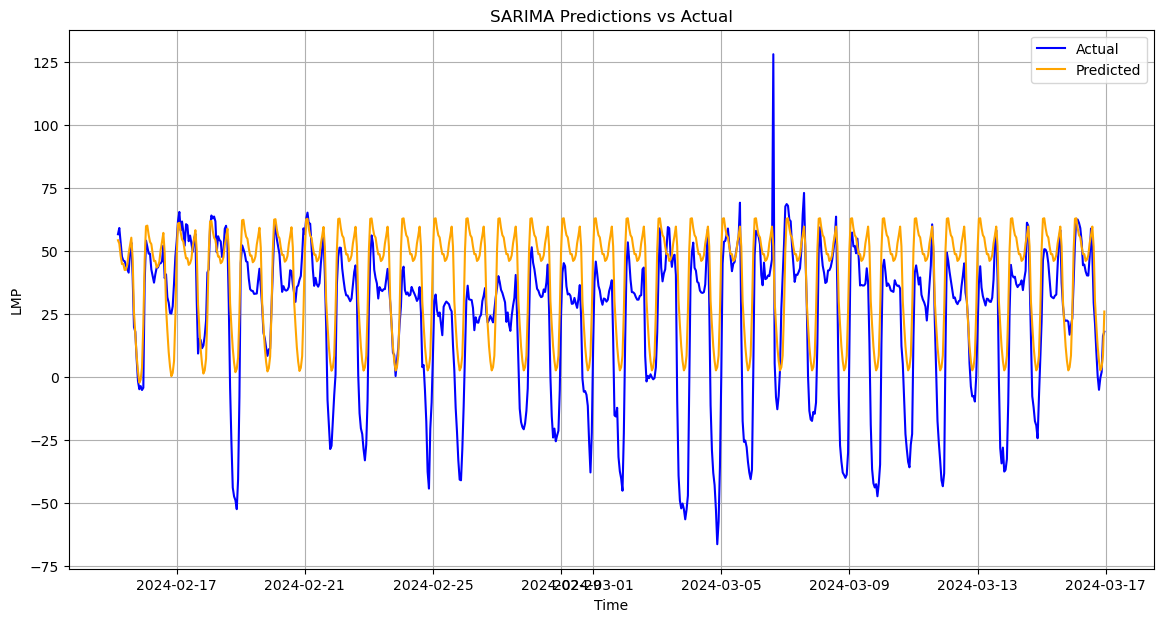

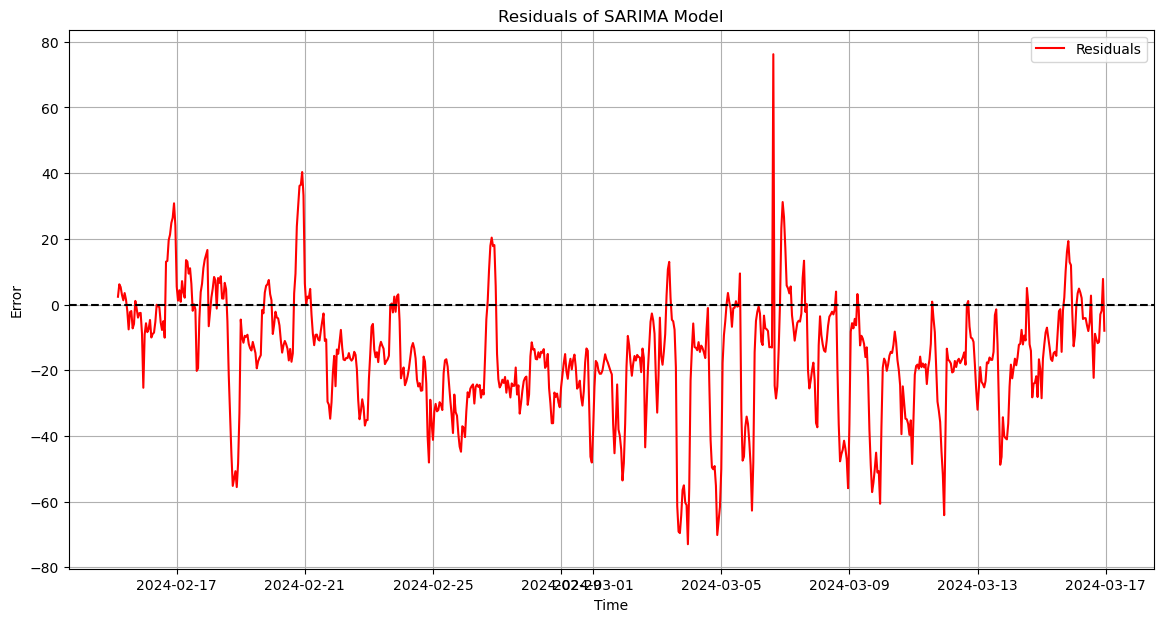

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

data = pd.read_csv('./data_seg8.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

# Filter for the specified range
filtered_data = data.loc['2023-10-15':'2024-03-16']

# Assign hourly frequency and handle missing values
filtered_data = filtered_data.asfreq('H')
filtered_data = filtered_data.fillna(method='ffill')

# Split the data to training and testing sets
train_size = int(len(filtered_data) * 0.8)
train, test = filtered_data['LMP'][:train_size], filtered_data['LMP'][train_size:]

# Define the best SARIMA parameters
sarima_order_best = (2, 0, 2)
seasonal_order_best = (1, 1, 1, 24)

# Fit the SARIMA model with the best parameters
model_best = SARIMAX(train, order=sarima_order_best, seasonal_order=seasonal_order_best, enforce_stationarity=False, enforce_invertibility=False)
sarima_fit_best = model_best.fit(disp=False)

# Forecast on the test set
test_predictions_best = sarima_fit_best.predict(start=test.index[0], end=test.index[-1])

rmse_best = np.sqrt(mean_squared_error(test, test_predictions_best))

print("RMSE:", rmse_best)
print(sarima_fit_best.summary())

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test, label='Actual', color='blue')
plt.plot(test_predictions_best, label='Predicted', color='orange')
plt.title('SARIMA Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('LMP')
plt.legend()
plt.grid()
plt.show()

# Plot residuals (errors)
residuals = test - test_predictions_best
plt.figure(figsize=(14, 7))
plt.plot(residuals, label='Residuals', color='red')
plt.axhline(0, linestyle='--', color='black')
plt.title('Residuals of SARIMA Model')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()

### Prediction on the test dataset

C:\Users\isaac\AppData\Local\Temp\ipykernel_20760\4101615916.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data = filtered_data.asfreq('H').fillna(method='ffill')


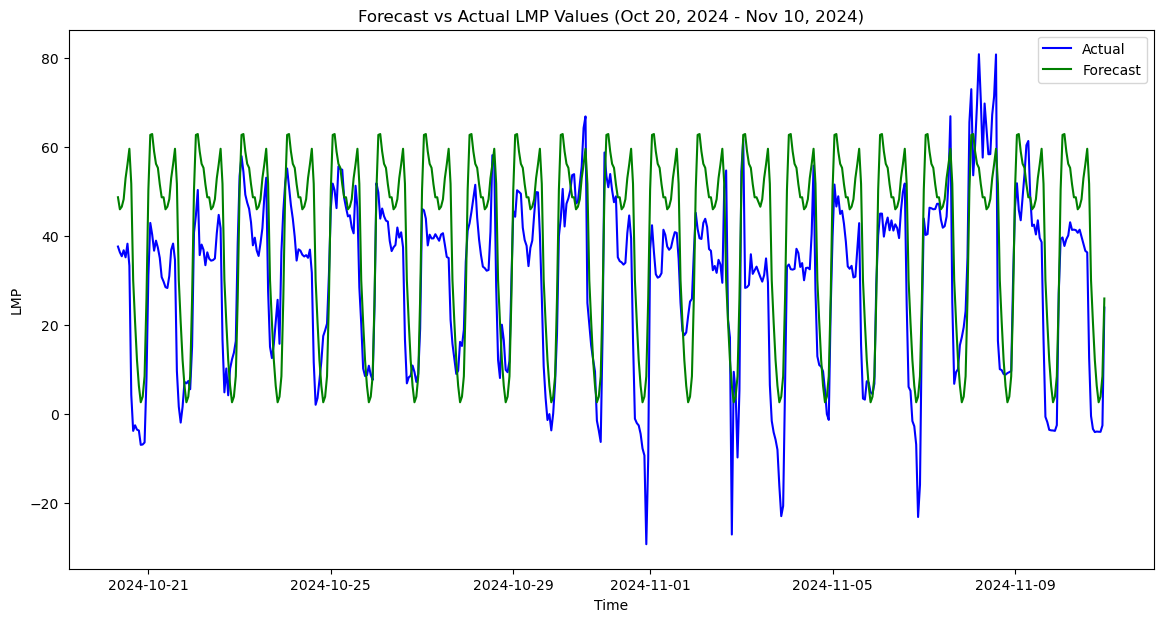

RMSE for the Forecasted Range: 15.644757566109291


In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

actual_data = pd.read_csv('./data_seg8.csv')
actual_data['Time'] = pd.to_datetime(actual_data['Time'])
actual_data.set_index('Time', inplace=True)

# Filter the actual data for the forecasted range
actual_values = actual_data.loc['2024-10-20':'2024-11-10', 'LMP']

data = pd.read_csv('./data_seg8.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

filtered_data = data.loc['2023-10-15':'2024-03-16']
filtered_data = filtered_data.asfreq('H').fillna(method='ffill')
train_size = int(len(filtered_data) * 0.8)
train = filtered_data['LMP'][:train_size]

# Fit SARIMA model with best parameters
sarima_order_best = (2, 0, 2)
seasonal_order_best = (1, 1, 1, 24)
model_best = SARIMAX(train, order=sarima_order_best, seasonal_order=seasonal_order_best, enforce_stationarity=False, enforce_invertibility=False)
sarima_fit_best = model_best.fit(disp=False)

# Forecast for the desired range
forecast_start = '2024-10-20 00:00:00'
forecast_end = '2024-11-10 23:00:00'
future_forecast = sarima_fit_best.get_prediction(start=forecast_start, end=forecast_end)
forecast_mean = future_forecast.predicted_mean

forecast_mean_aligned = forecast_mean.reindex(actual_values.index)

plt.figure(figsize=(14, 7))
plt.plot(actual_values, label='Actual', color='blue')
plt.plot(forecast_mean_aligned, label='Forecast', color='green')
plt.title('Forecast vs Actual LMP Values (Oct 20, 2024 - Nov 10, 2024)')
plt.xlabel('Time')
plt.ylabel('LMP')
plt.legend()
plt.show()

rmse_forecast = np.sqrt(mean_squared_error(actual_values, forecast_mean_aligned))
print("RMSE for the Forecasted Range:", rmse_forecast)


### Prediction on the Specific Interval (2024-11-01 4AM-11AM / 8AM-4PM) 


C:\Users\isaac\AppData\Local\Temp\ipykernel_20760\817520948.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data = filtered_data.asfreq('H').fillna(method='ffill')


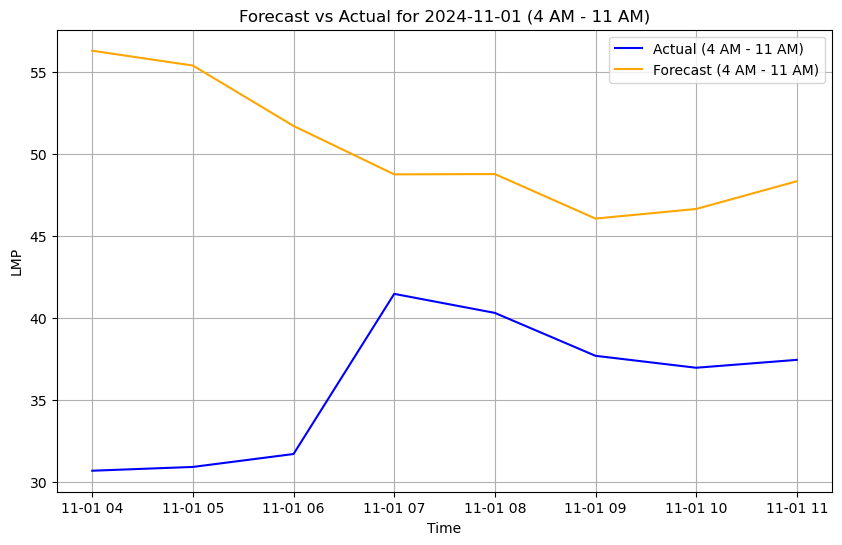

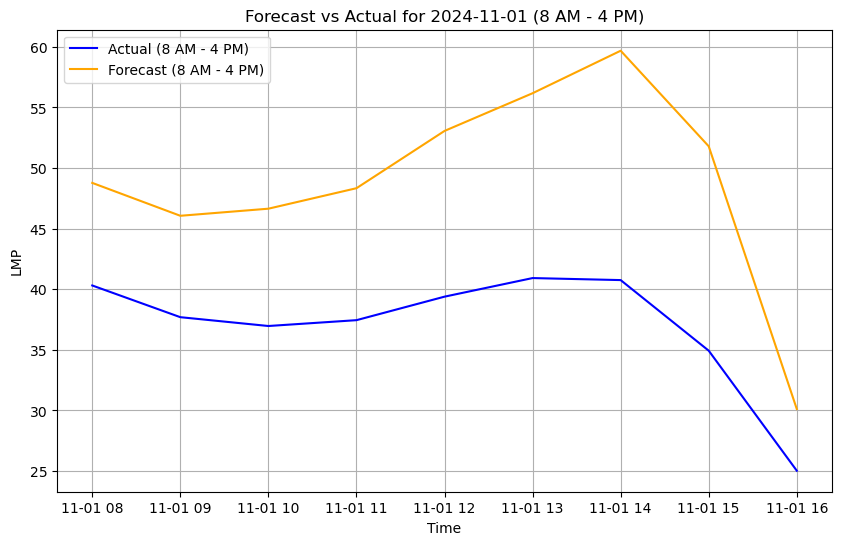

RMSE (4 AM - 11 AM): 16.04866084229751
RMSE (8 AM - 4 PM): 12.655110889781039


In [50]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

data = pd.read_csv('./data_seg8.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

# Preprocess the data for SARIMA
filtered_data = data.loc['2023-10-15':'2024-03-16']
filtered_data = filtered_data.asfreq('H').fillna(method='ffill')
train_size = int(len(filtered_data) * 0.8)
train = filtered_data['LMP'][:train_size]

# Fit SARIMA model with best parameters
sarima_order_best = (2, 0, 2)
seasonal_order_best = (1, 1, 1, 24)
model_best = SARIMAX(train, order=sarima_order_best, seasonal_order=seasonal_order_best, enforce_stationarity=False, enforce_invertibility=False)
sarima_fit_best = model_best.fit(disp=False)

# Define specific periods
forecast_start_1 = '2024-11-01 04:00:00'
forecast_end_1 = '2024-11-01 11:00:00'
forecast_start_2 = '2024-11-01 08:00:00'
forecast_end_2 = '2024-11-01 16:00:00'

# Make predictions
future_forecast_1 = sarima_fit_best.get_prediction(start=forecast_start_1, end=forecast_end_1)
forecast_mean_1 = future_forecast_1.predicted_mean

future_forecast_2 = sarima_fit_best.get_prediction(start=forecast_start_2, end=forecast_end_2)
forecast_mean_2 = future_forecast_2.predicted_mean

# Extract actual values
actual_values_1 = data.loc[forecast_start_1:forecast_end_1, 'LMP']
actual_values_2 = data.loc[forecast_start_2:forecast_end_2, 'LMP']

# Align predictions
forecast_mean_1_aligned = forecast_mean_1.reindex(actual_values_1.index)
forecast_mean_2_aligned = forecast_mean_2.reindex(actual_values_2.index)

# Plot for period 1
plt.figure(figsize=(10, 6))
plt.plot(actual_values_1, label='Actual (4 AM - 11 AM)', color='blue')
plt.plot(forecast_mean_1_aligned, label='Forecast (4 AM - 11 AM)', color='orange')
plt.title('Forecast vs Actual for 2024-11-01 (4 AM - 11 AM)')
plt.xlabel('Time')
plt.ylabel('LMP')
plt.legend()
plt.grid()
plt.show()

# Plot for period 2
plt.figure(figsize=(10, 6))
plt.plot(actual_values_2, label='Actual (8 AM - 4 PM)', color='blue')
plt.plot(forecast_mean_2_aligned, label='Forecast (8 AM - 4 PM)', color='orange')
plt.title('Forecast vs Actual for 2024-11-01 (8 AM - 4 PM)')
plt.xlabel('Time')
plt.ylabel('LMP')
plt.legend()
plt.grid()
plt.show()

rmse_1 = np.sqrt(mean_squared_error(actual_values_1, forecast_mean_1_aligned))
rmse_2 = np.sqrt(mean_squared_error(actual_values_2, forecast_mean_2_aligned))

print("RMSE (4 AM - 11 AM):", rmse_1)
print("RMSE (8 AM - 4 PM):", rmse_2)


### Average Hourly Prediction (2024, Nov 1 - Nov 10)

In [61]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

data = pd.read_csv('./data_seg8.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

# Preprocess the data for SARIMA
filtered_data = data.loc['2023-10-15':'2024-03-16']
filtered_data = filtered_data.asfreq('H').fillna(method='ffill')
train_size = int(len(filtered_data) * 0.8)
train = filtered_data['LMP'][:train_size]

# Fit SARIMA model with best parameters
sarima_order_best = (2, 0, 2)
seasonal_order_best = (1, 1, 1, 24)
model_best = SARIMAX(train, order=sarima_order_best, seasonal_order=seasonal_order_best, enforce_stationarity=False, enforce_invertibility=False)
sarima_fit_best = model_best.fit(disp=False)

# Define the range for November 1, 2024, to November 10, 2024
forecast_start_full = '2024-11-01 00:00:00'
forecast_end_full = '2024-11-10 23:00:00'

# Generate predictions for the full range
future_forecast_full = sarima_fit_best.get_prediction(start=forecast_start_full, end=forecast_end_full)
forecast_mean_full = future_forecast_full.predicted_mean

# Calculate the average hourly prediction
average_hourly_prediction = forecast_mean_full.mean()

print("Average Hourly Prediction (Nov 1 - Nov 10, 2024):", average_hourly_prediction)

C:\Users\isaac\AppData\Local\Temp\ipykernel_20760\2773173486.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data = filtered_data.asfreq('H').fillna(method='ffill')


Average Hourly Prediction (Nov 1 - Nov 10, 2024): 40.353672632884255


# Segment 9 SARIMA

### SARIMA Parameter Tuning Using Grid Search


In [7]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

data = pd.read_csv('./data_seg9.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)
filtered_data = data.loc['2023-10-15':'2024-03-16']

# Assign hourly frequency and handle missing values
filtered_data = filtered_data.asfreq('H')
filtered_data = filtered_data.fillna(method='ffill')

# Split data into train and test sets
train_size = int(len(filtered_data) * 0.8)
train, test = filtered_data['LMP'][:train_size], filtered_data['LMP'][train_size:]

# Grid search for SARIMA parameters
def sarima_grid_search(train, p_values, d_values, q_values, P_values, D_values, Q_values, s):
    best_aic = float("inf")
    best_params = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                model = SARIMAX(
                                    train,
                                    order=(p, d, q),
                                    seasonal_order=(P, D, Q, s),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False
                                )
                                model_fit = model.fit(disp=False)
                                aic = model_fit.aic
                                if aic < best_aic:
                                    best_aic = aic
                                    best_params = (p, d, q, P, D, Q, s)
                            except:
                                continue
    return best_params, best_aic

# Define SARIMA parameter ranges
p_values = [0, 1, 2]
d_values = [0, 1] # Should be 0 since the time series is farily staionary. 
q_values = [0, 1, 2]
P_values = [0, 1]
D_values = [0, 1]
Q_values = [0, 1]
s = 24  # Daily seasonality

# Perform grid search
best_params, best_aic = sarima_grid_search(train, p_values, d_values, q_values, P_values, D_values, Q_values, s)
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)


C:\Users\isaac\AppData\Local\Temp\ipykernel_20760\3020298472.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data = filtered_data.fillna(method='ffill')
C:\Users\isaac\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best Parameters: (2, 0, 2, 1, 1, 1, 24)
Best AIC: 21791.85044043481


### Tuned Model Performance and Prediction on the Training Dataset


C:\Users\isaac\AppData\Local\Temp\ipykernel_20760\929347310.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data = filtered_data.fillna(method='ffill')


RMSE: 22.453726112393202
                                      SARIMAX Results                                       
Dep. Variable:                                  LMP   No. Observations:                 2956
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 24)   Log Likelihood              -10888.925
Date:                              Thu, 21 Nov 2024   AIC                          21791.850
Time:                                      18:11:25   BIC                          21833.670
Sample:                                  10-15-2023   HQIC                         21806.917
                                       - 02-15-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7828      0.023     79.108      0.000       1.739       

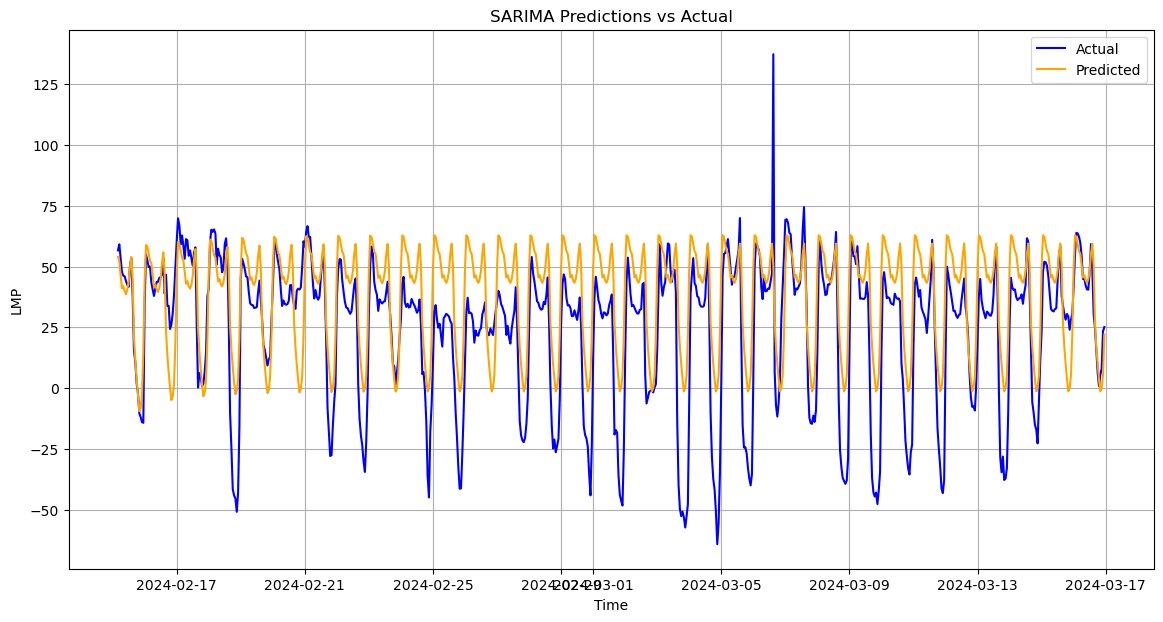

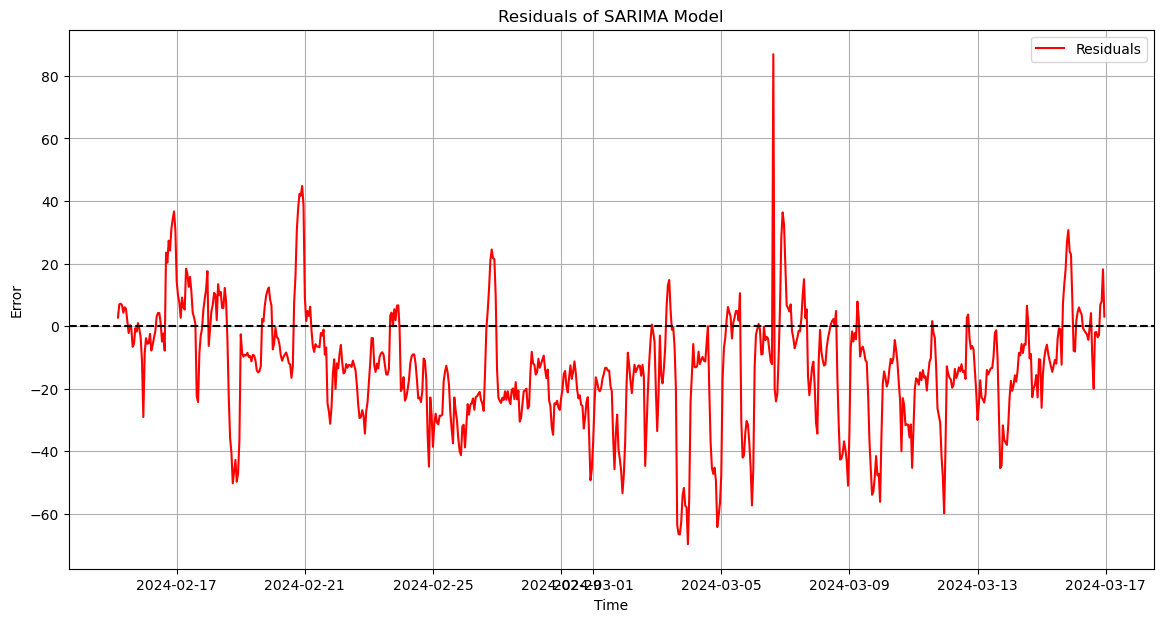

In [9]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

data = pd.read_csv('./data_seg9.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

# Filter for the specified range
filtered_data = data.loc['2023-10-15':'2024-03-16']

# Assign hourly frequency and handle missing values
filtered_data = filtered_data.asfreq('H')
filtered_data = filtered_data.fillna(method='ffill')

# Split the data into training and testing sets
train_size = int(len(filtered_data) * 0.8)
train, test = filtered_data['LMP'][:train_size], filtered_data['LMP'][train_size:]

# Define the best SARIMA parameters
sarima_order_best = (2, 0, 2)
seasonal_order_best = (1, 1, 1, 24)

# Fit the SARIMA model with the best parameters
model_best = SARIMAX(train, order=sarima_order_best, seasonal_order=seasonal_order_best, enforce_stationarity=False, enforce_invertibility=False)
sarima_fit_best = model_best.fit(disp=False)

# Forecast on the test set
test_predictions_best = sarima_fit_best.predict(start=test.index[0], end=test.index[-1])

rmse_best = np.sqrt(mean_squared_error(test, test_predictions_best))

print("RMSE:", rmse_best)
print(sarima_fit_best.summary())

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test, label='Actual', color='blue')
plt.plot(test_predictions_best, label='Predicted', color='orange')
plt.title('SARIMA Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('LMP')
plt.legend()
plt.grid()
plt.show()

# Plot residuals (errors)
residuals = test - test_predictions_best
plt.figure(figsize=(14, 7))
plt.plot(residuals, label='Residuals', color='red')
plt.axhline(0, linestyle='--', color='black')
plt.title('Residuals of SARIMA Model')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()

### Prediction on the test dataset

C:\Users\isaac\AppData\Local\Temp\ipykernel_20760\1596486289.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data = filtered_data.asfreq('H').fillna(method='ffill')


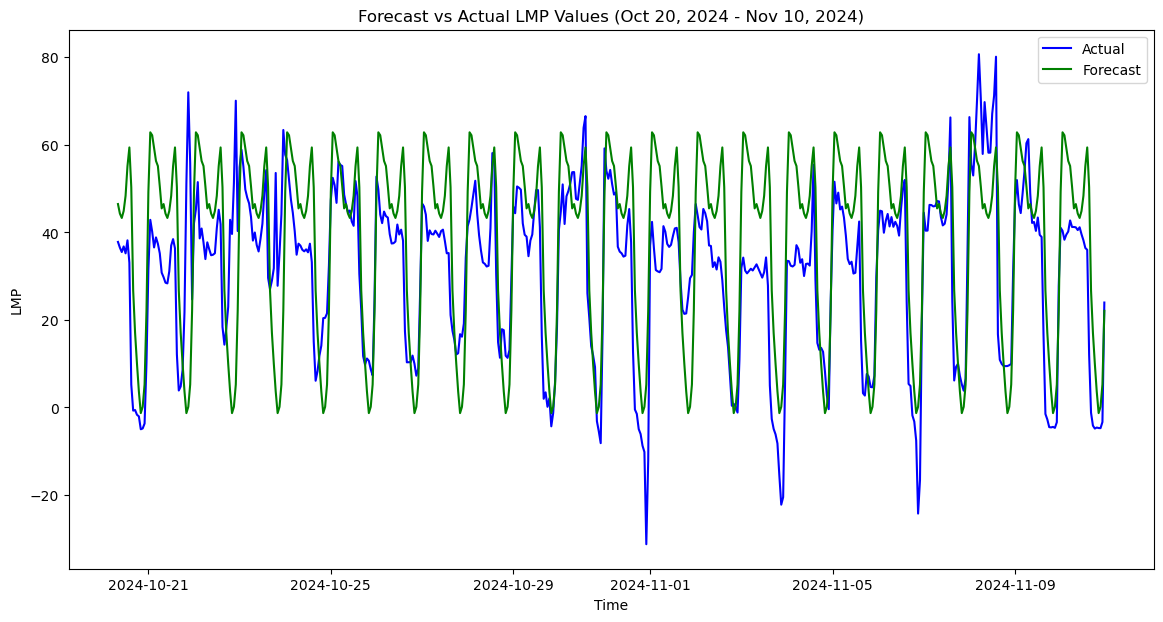

RMSE for the Forecasted Range: 16.21597084207072


In [13]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

actual_data = pd.read_csv('./data_seg9.csv')
actual_data['Time'] = pd.to_datetime(actual_data['Time'])
actual_data.set_index('Time', inplace=True)

# Filter the actual data for the forecasted range
actual_values = actual_data.loc['2024-10-20':'2024-11-10', 'LMP']

# Reload original dataset for SARIMA fitting
data = pd.read_csv('./data_seg9.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

filtered_data = data.loc['2023-10-15':'2024-03-16']
filtered_data = filtered_data.asfreq('H').fillna(method='ffill')
train_size = int(len(filtered_data) * 0.8)
train = filtered_data['LMP'][:train_size]

# Fit SARIMA model with best parameters
sarima_order_best = (2, 0, 2)
seasonal_order_best = (1, 1, 1, 24)
model_best = SARIMAX(train, order=sarima_order_best, seasonal_order=seasonal_order_best, enforce_stationarity=False, enforce_invertibility=False)
sarima_fit_best = model_best.fit(disp=False)

# Forecast for the desired range
forecast_start = '2024-10-20 00:00:00'
forecast_end = '2024-11-10 23:00:00'
future_forecast = sarima_fit_best.get_prediction(start=forecast_start, end=forecast_end)
forecast_mean = future_forecast.predicted_mean

forecast_mean_aligned = forecast_mean.reindex(actual_values.index)

# Compare actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actual_values, label='Actual', color='blue')
plt.plot(forecast_mean_aligned, label='Forecast', color='green')
plt.title('Forecast vs Actual LMP Values (Oct 20, 2024 - Nov 10, 2024)')
plt.xlabel('Time')
plt.ylabel('LMP')
plt.legend()
plt.show()

# Calculate RMSE after alignment
rmse_forecast = np.sqrt(mean_squared_error(actual_values, forecast_mean_aligned))
print("RMSE for the Forecasted Range:", rmse_forecast)


### Prediction on the Specific Interval (2024-11-01 4AM-11AM / 8AM-4PM) 


C:\Users\isaac\AppData\Local\Temp\ipykernel_20760\1376083212.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data = filtered_data.asfreq('H').fillna(method='ffill')


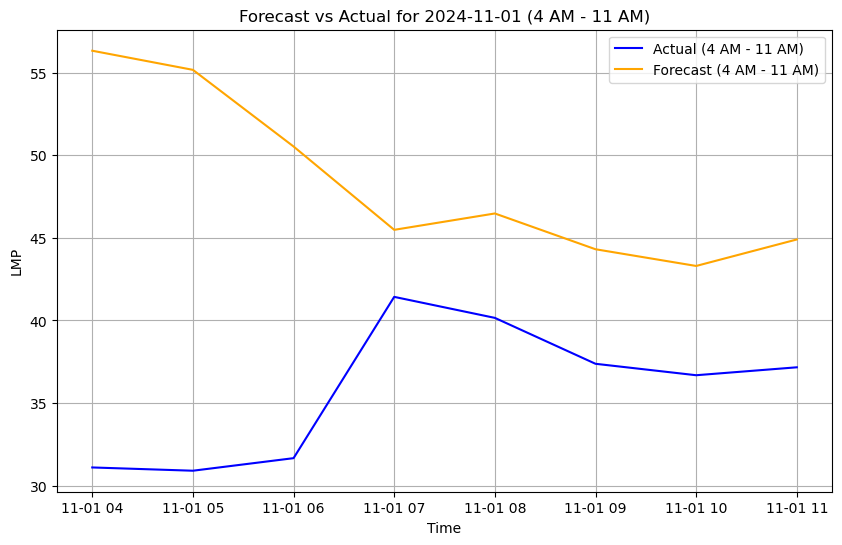

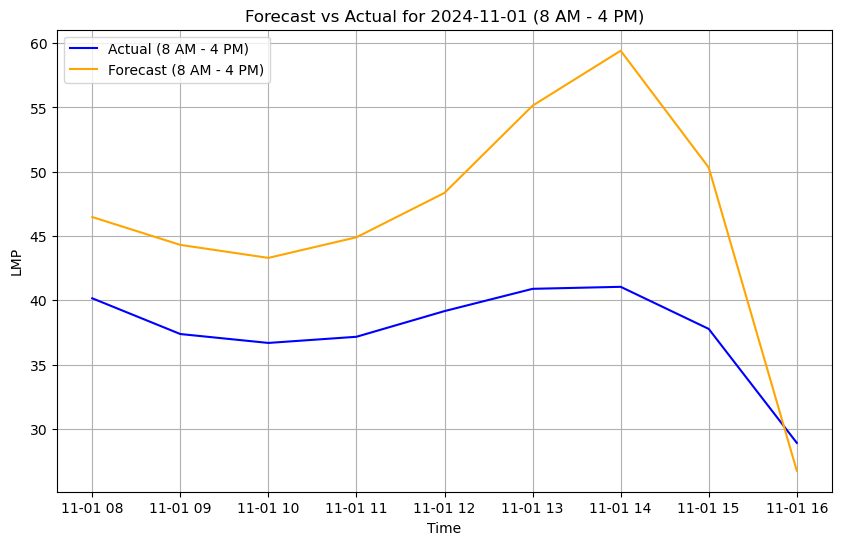

RMSE (4 AM - 11 AM): 14.955150586451436
RMSE (8 AM - 4 PM): 10.42690307312509


In [52]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

data = pd.read_csv('./data_seg9.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

# Preprocess the data for SARIMA
filtered_data = data.loc['2023-10-15':'2024-03-16']
filtered_data = filtered_data.asfreq('H').fillna(method='ffill')
train_size = int(len(filtered_data) * 0.8)
train = filtered_data['LMP'][:train_size]

# Fit SARIMA model with best parameters
sarima_order_best = (2, 0, 2)
seasonal_order_best = (1, 1, 1, 24)
model_best = SARIMAX(train, order=sarima_order_best, seasonal_order=seasonal_order_best, enforce_stationarity=False, enforce_invertibility=False)
sarima_fit_best = model_best.fit(disp=False)

# Define specific periods
forecast_start_1 = '2024-11-01 04:00:00'
forecast_end_1 = '2024-11-01 11:00:00'
forecast_start_2 = '2024-11-01 08:00:00'
forecast_end_2 = '2024-11-01 16:00:00'

# Make predictions
future_forecast_1 = sarima_fit_best.get_prediction(start=forecast_start_1, end=forecast_end_1)
forecast_mean_1 = future_forecast_1.predicted_mean

future_forecast_2 = sarima_fit_best.get_prediction(start=forecast_start_2, end=forecast_end_2)
forecast_mean_2 = future_forecast_2.predicted_mean

# Extract actual values
actual_values_1 = data.loc[forecast_start_1:forecast_end_1, 'LMP']
actual_values_2 = data.loc[forecast_start_2:forecast_end_2, 'LMP']

# Align predictions
forecast_mean_1_aligned = forecast_mean_1.reindex(actual_values_1.index)
forecast_mean_2_aligned = forecast_mean_2.reindex(actual_values_2.index)

# Plot for period 1
plt.figure(figsize=(10, 6))
plt.plot(actual_values_1, label='Actual (4 AM - 11 AM)', color='blue')
plt.plot(forecast_mean_1_aligned, label='Forecast (4 AM - 11 AM)', color='orange')
plt.title('Forecast vs Actual for 2024-11-01 (4 AM - 11 AM)')
plt.xlabel('Time')
plt.ylabel('LMP')
plt.legend()
plt.grid()
plt.show()

# Plot for period 2
plt.figure(figsize=(10, 6))
plt.plot(actual_values_2, label='Actual (8 AM - 4 PM)', color='blue')
plt.plot(forecast_mean_2_aligned, label='Forecast (8 AM - 4 PM)', color='orange')
plt.title('Forecast vs Actual for 2024-11-01 (8 AM - 4 PM)')
plt.xlabel('Time')
plt.ylabel('LMP')
plt.legend()
plt.grid()
plt.show()

rmse_1 = np.sqrt(mean_squared_error(actual_values_1, forecast_mean_1_aligned))
rmse_2 = np.sqrt(mean_squared_error(actual_values_2, forecast_mean_2_aligned))

print("RMSE (4 AM - 11 AM):", rmse_1)
print("RMSE (8 AM - 4 PM):", rmse_2)


### Average Hourly Prediction (2024, Nov 1 - Nov 10)

In [63]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

data = pd.read_csv('./data_seg9.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

# Preprocess the data for SARIMA
filtered_data = data.loc['2023-10-15':'2024-03-16']
filtered_data = filtered_data.asfreq('H').fillna(method='ffill')
train_size = int(len(filtered_data) * 0.8)
train = filtered_data['LMP'][:train_size]

# Fit SARIMA model with best parameters
sarima_order_best = (2, 0, 2)
seasonal_order_best = (1, 1, 1, 24)
model_best = SARIMAX(train, order=sarima_order_best, seasonal_order=seasonal_order_best, enforce_stationarity=False, enforce_invertibility=False)
sarima_fit_best = model_best.fit(disp=False)

# Define the range for November 1, 2024, to November 10, 2024
forecast_start_full = '2024-11-01 00:00:00'
forecast_end_full = '2024-11-10 23:00:00'

# Generate predictions for the full range
future_forecast_full = sarima_fit_best.get_prediction(start=forecast_start_full, end=forecast_end_full)
forecast_mean_full = future_forecast_full.predicted_mean

# Calculate the average hourly prediction
average_hourly_prediction = forecast_mean_full.mean()

print("Average Hourly Prediction (Nov 1 - Nov 10, 2024):", average_hourly_prediction)

C:\Users\isaac\AppData\Local\Temp\ipykernel_20760\2794225305.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data = filtered_data.asfreq('H').fillna(method='ffill')


Average Hourly Prediction (Nov 1 - Nov 10, 2024): 38.20185737710138
